# Race Events

Simple attempts at identifying race related events.

In [1]:
#using notebook rather than inline enables 3D matplotlib plots
%matplotlib inline

import pandas as pd

In [2]:
url = 'http://fiawec.alkamelsystems.com/Results/08_2018-2019/07_SPA%20FRANCORCHAMPS/267_FIA%20WEC/201905041330_Race/Hour%206/23_Analysis_Race_Hour%206.CSV'


In [3]:
laptimes = pd.read_csv(url, sep=';').dropna(how='all', axis=1)
laptimes.columns = [c.strip() for c in laptimes.columns]

#Tidy the data a little... car and driver number are not numbers
laptimes[['NUMBER','DRIVER_NUMBER']] = laptimes[['NUMBER','DRIVER_NUMBER']].astype(str)

## Core Enrichment

Really need to move the df enrichment into a utils fn before the tech debt gets too much!


In [4]:
#Add the parent dir to the import path
import sys
sys.path.append("..")

#Import contents of the utils.py package in the parent directory
from py.utils import *

#Get laptimes in seconds
laptimes['LAP_TIME_S'] = laptimes['LAP_TIME'].apply(getTime)

#Find accumulated time in seconds
laptimes['ELAPSED_S']=laptimes['ELAPSED'].apply(getTime)

#Find position based on accumulated laptime
laptimes = laptimes.sort_values('ELAPSED_S')
laptimes['POS'] = laptimes.groupby('LAP_NUMBER')['ELAPSED_S'].rank()

#Find leader naively
laptimes['leader'] = laptimes['POS']==1

#Find lead lap number
laptimes['LEAD_LAP_NUMBER'] = laptimes['leader'].cumsum()

laptimes.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,PIT_TIME,CLASS,GROUP,TEAM,MANUFACTURER,LAP_TIME_S,ELAPSED_S,POS,leader,LEAD_LAP_NUMBER
2381,7,1,1,2:00.155,0,NaN,33.767,0,56.631,0,...,NaN,LMP1,H,Toyota Gazoo Racing,Toyota,120.155,120.155,1.0,True,1
2876,8,1,1,2:01.977,0,NaN,34.280,0,57.610,0,...,NaN,LMP1,H,Toyota Gazoo Racing,Toyota,121.977,121.977,2.0,False,1
262,17,1,1,2:03.259,0,NaN,35.742,0,56.454,0,...,NaN,LMP1,NaN,SMP Racing,BR Engineering,123.259,123.259,3.0,False,1
777,3,2,1,2:03.739,0,NaN,36.035,0,56.644,0,...,NaN,LMP1,NaN,Rebellion Racing,Rebellion,123.739,123.739,4.0,False,1
130,11,3,1,2:05.631,0,NaN,37.247,0,57.103,0,...,NaN,LMP1,NaN,SMP Racing,BR Engineering,125.631,125.631,5.0,False,1


In [5]:
# TO DO - check laps where a car is lapped or unlaps to see we have the correct lap, lead lap and time data

# A car may miss a lead lap number if it is lapped. So in the race history what happens?

## LapTime Distribution

Eyeball the laptime distribution just to get a feel for it.

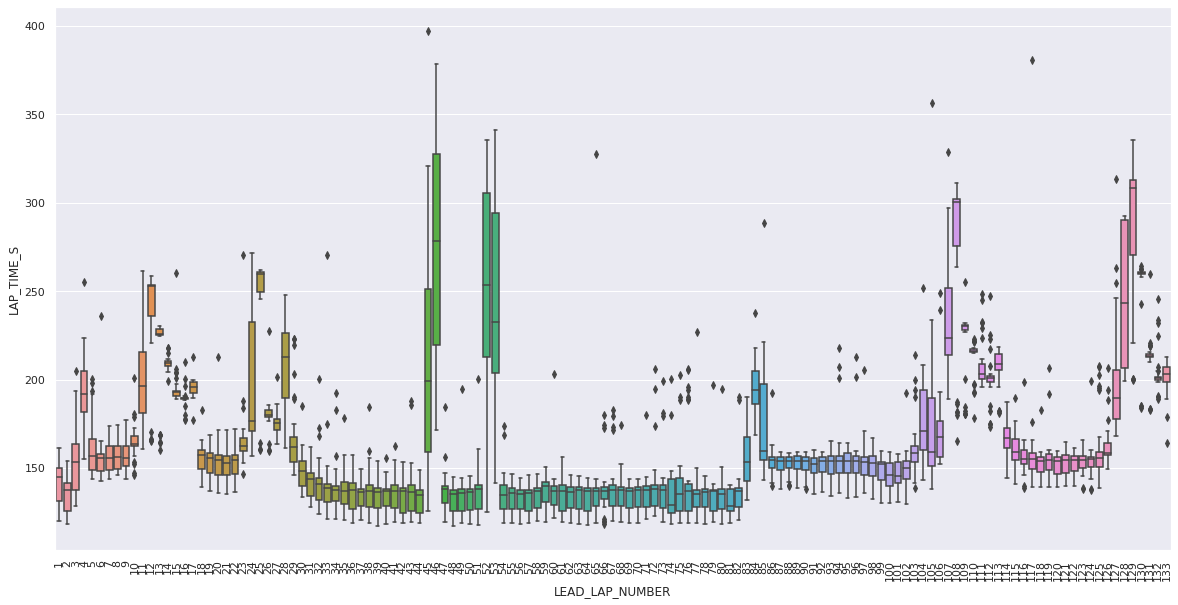

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500])
plt.xticks(rotation=90);

Can we get signal from the differerces between fastest lap time per lead lap?

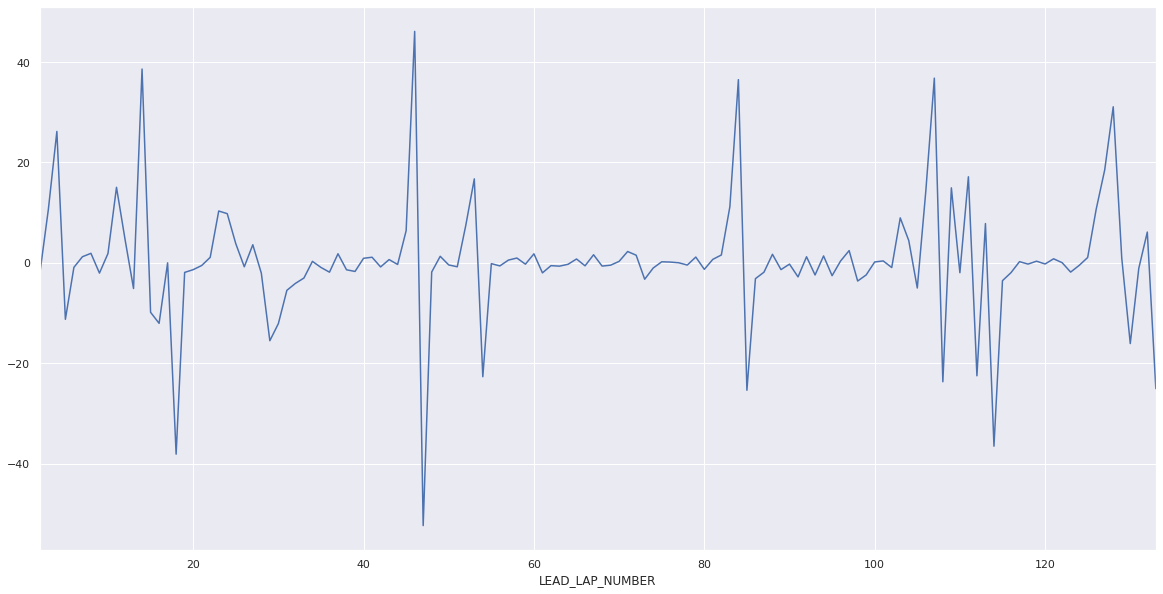

In [7]:
laptimes.groupby(['LEAD_LAP_NUMBER'])['LAP_TIME_S'].min().diff()[1:].plot()

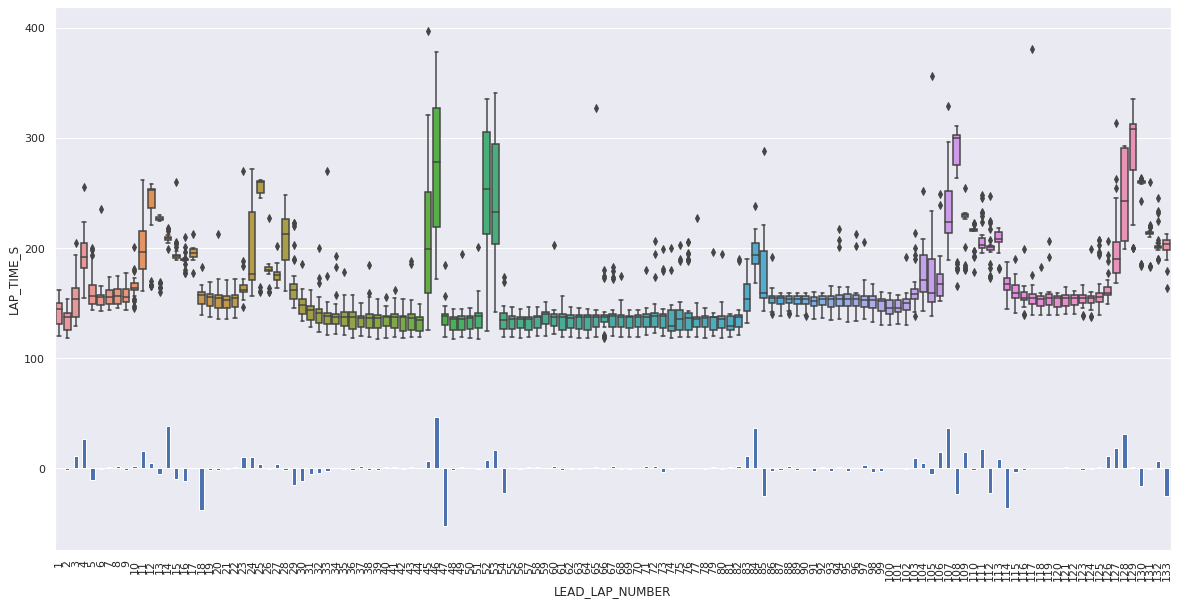

In [8]:
#WHy find the min here? TO DO
ax2 = laptimes.groupby(['LEAD_LAP_NUMBER'])['LAP_TIME_S'].min().diff().fillna(0).plot(kind='bar')
sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500], ax=ax2)
sns.set(rc={'figure.figsize':(20,10)})
ax2;

## Slow Laps

Slow laps may be a safety car, may be yellow flags, may be the weather...

Start by identifying median and standard deviation of laptimes on a per lead lap basis.

In [9]:
#pandas 0,25?
#laptimes_summary_stats = laptimes.groupby(['LEAD_LAP_NUMBER']).agg(median_lap_time_s=('LAP_TIME_S', 'median'),
#                                                                   sd_lap_time_s=('LAP_TIME_S', 'std'))

laptimes_summary_stats = laptimes.groupby(['LEAD_LAP_NUMBER']).agg({'LAP_TIME_S':['mean', 'median','std', 'max']})

laptimes_summary_stats.columns = laptimes_summary_stats.columns.get_level_values(1)

laptimes_summary_stats.head()

,mean,median,std,max
LEAD_LAP_NUMBER,,,,
1,141.082912,144.699,12.183414,161.521
2,133.496618,137.736,9.691920,153.997
3,153.886636,153.401,18.891562,204.561
4,192.534118,191.853,20.749068,255.287
5,162.354806,156.618,16.789378,200.416


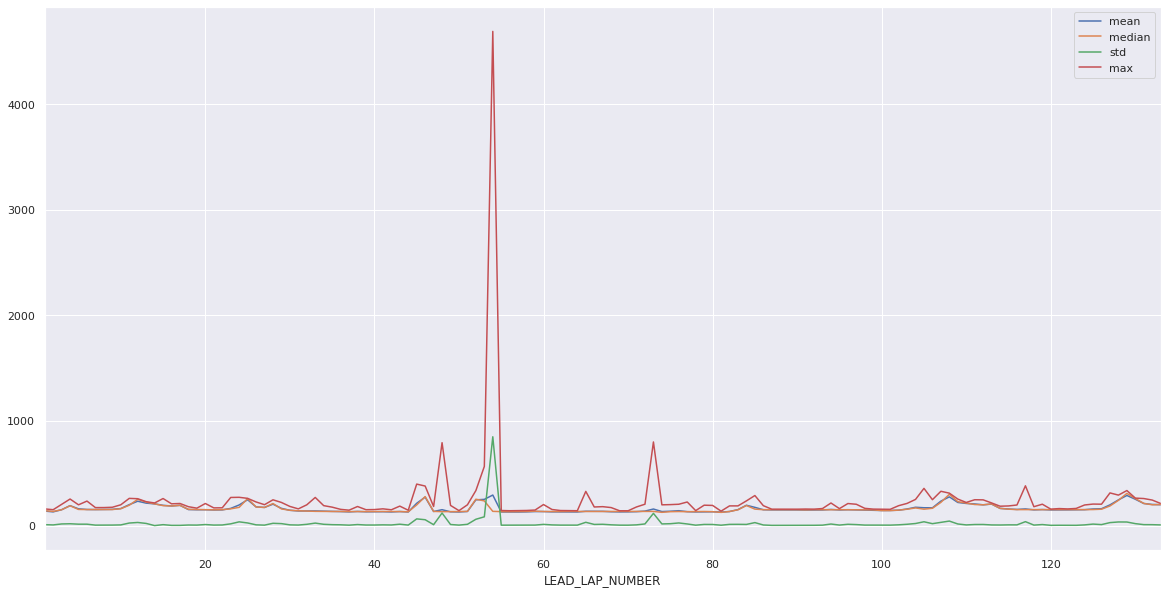

In [10]:
laptimes_summary_stats.plot()

Okay, so we have at least one outlier.

Let's look for others... say, laptimes with a z-score of more than 3, which is to say, more than 3 standard deviations away from the mean.

In [11]:
from scipy import stats
import numpy as np

laptimes[(np.abs(stats.zscore(laptimes['LAP_TIME_S'])) > 3)]

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,PIT_TIME,CLASS,GROUP,TEAM,MANUFACTURER,LAP_TIME_S,ELAPSED_S,POS,leader,LEAD_LAP_NUMBER
3417,88,1,40,13:09.671,0,B,42.374,0,11:37.235,0,...,NaN,LMGTE Am,NaN,Dempsey - Proton Racing,Porsche,789.671,7607.874,33.0,False,48
3420,88,2,43,9:24.410,0,NaN,7:38.393,0,1:09.759,0,...,0:06:53.908,LMGTE Am,NaN,Dempsey - Proton Racing,Porsche,564.410,8527.752,33.0,False,53
1445,4,2,23,1:18:10.896,0,NaN,1:16:28.761,0,1:05.649,0,...,1:15:55.240,LMP1,NaN,Bykolles Racing Team,Enso,4690.896,8530.598,34.0,False,54
2449,7,3,69,13:16.652,0,NaN,11:50.839,0,56.075,0,...,0:11:27.177,LMP1,H,Toyota Gazoo Racing,Toyota,796.652,11033.821,22.0,False,73


We don't really want `NaN` values in the laptimes, but for now lets create a set of "clean" laptimes that do `NaN` the outliers.

In [12]:
from numpy import NaN

laptimes['CLEAN_LAP_TIME_S'] = laptimes['LAP_TIME_S']

#If the zscore on a laptime is greater than three, set the CLEAN_LAP_TIME_S value to NaN
# else use the original value
laptimes.loc[np.abs(stats.zscore(laptimes['LAP_TIME_S'])) > 3, 'CLEAN_LAP_TIME_S'] = NaN

Now let's create the summary stats over the cleaned data.

In [13]:
laptimes_summary_stats = laptimes.groupby(['LEAD_LAP_NUMBER']).agg({'CLEAN_LAP_TIME_S':['mean', 'median','std', 'max']})

laptimes_summary_stats.columns = laptimes_summary_stats.columns.get_level_values(1)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


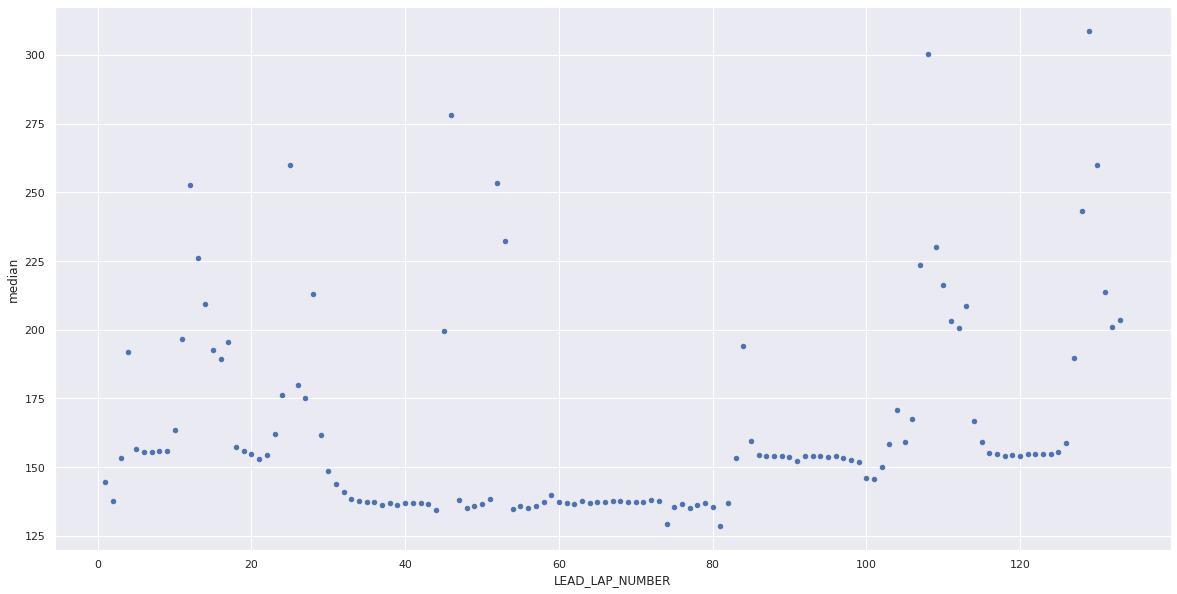

In [14]:
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='median')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


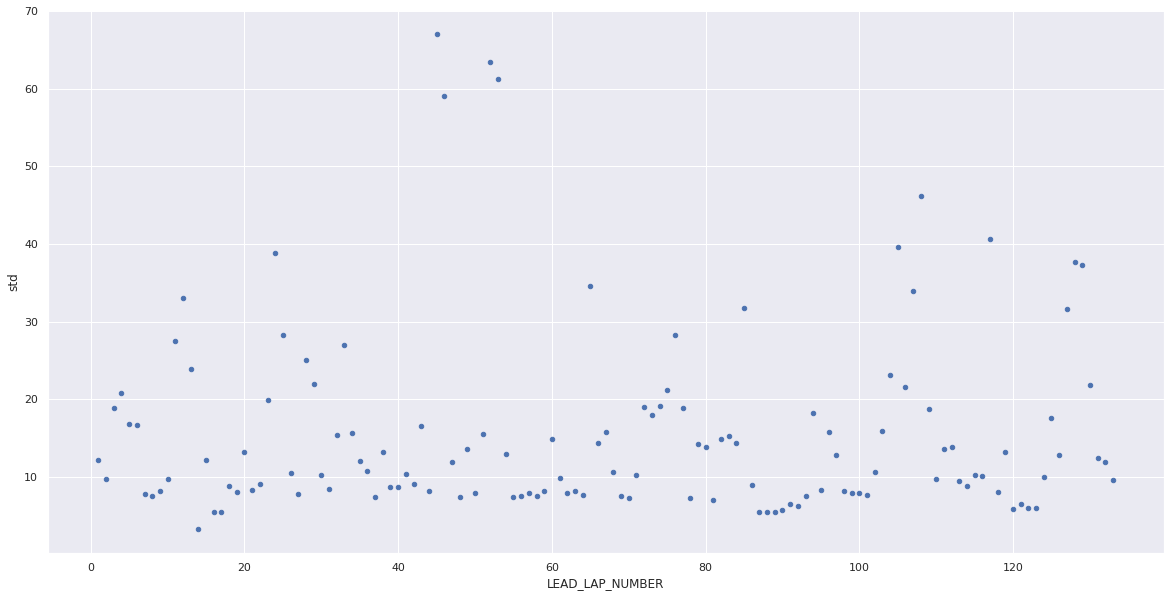

In [15]:
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='std')

<IPython.core.display.Javascript object>


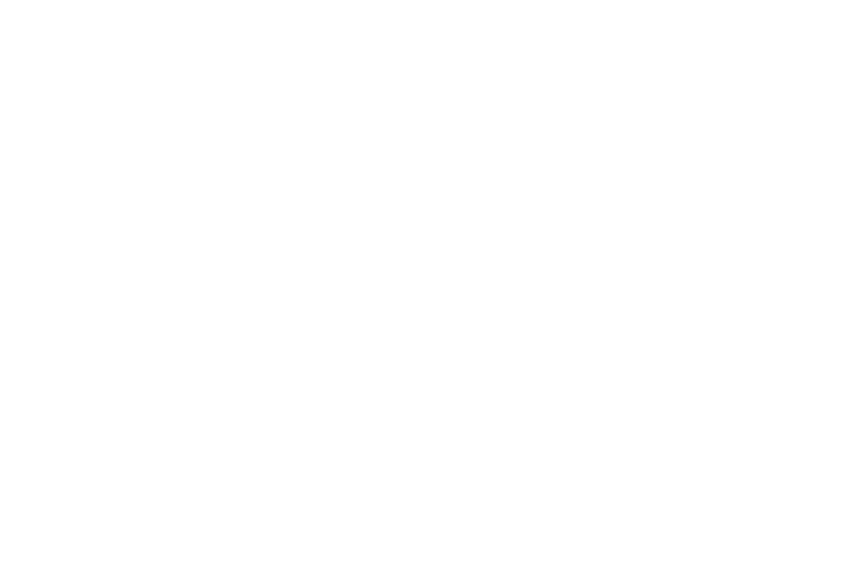

<IPython.core.display.Javascript object>


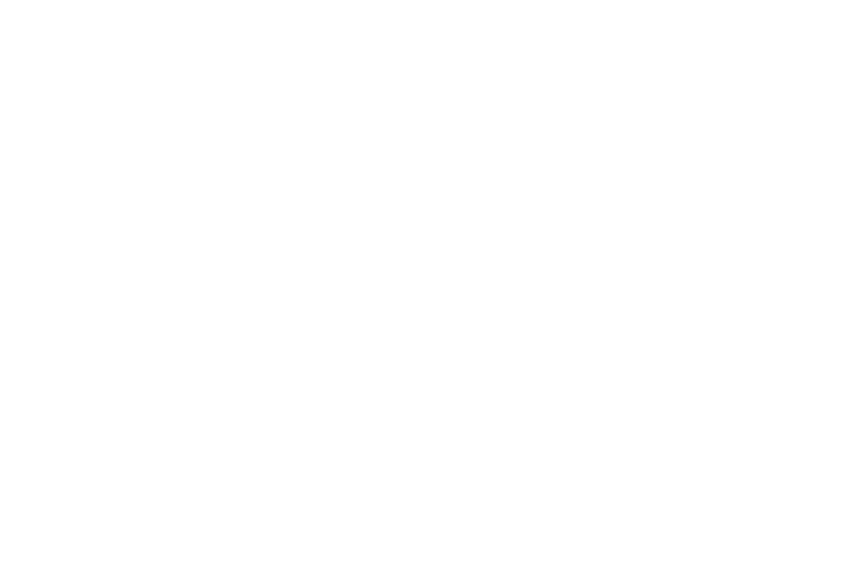

In [16]:
#laptimes_summary_stats.plot(kind='scatter', x='median', y='std')

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


scatter3d = plt.figure().gca(projection='3d')
scatter3d.scatter(laptimes_summary_stats.index, laptimes_summary_stats['std'], laptimes_summary_stats['median'])

## Pit Events Per Lap

Is there any signal to be had from pit events per lap?

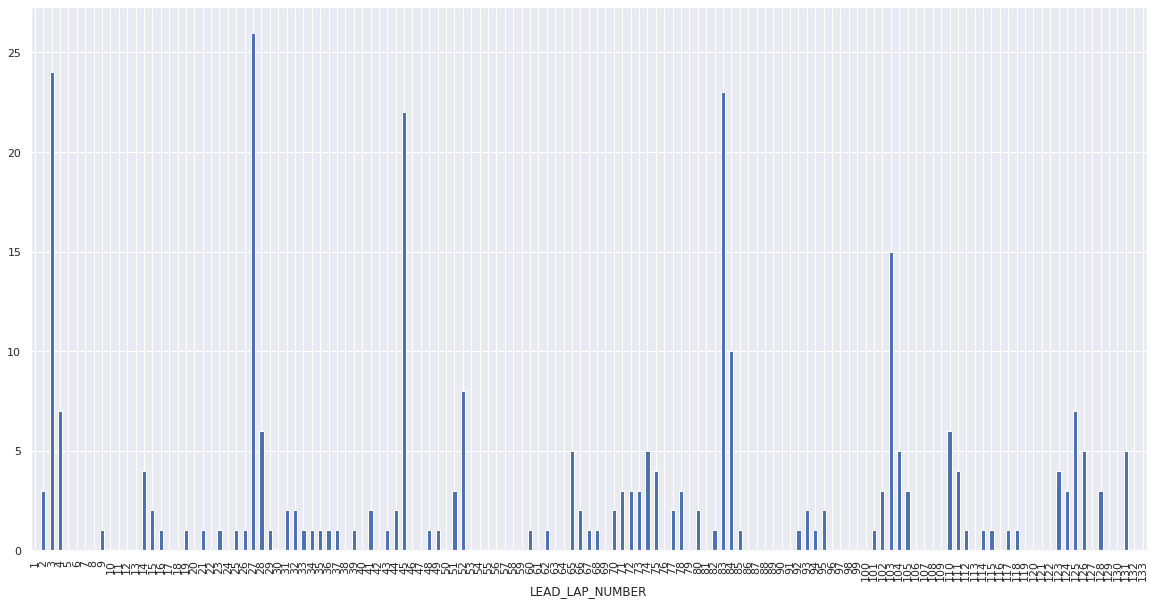

In [17]:
%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})

laptimes['INLAP'] = laptimes['CROSSING_FINISH_LINE_IN_PIT']== 'B'
laptimes.groupby('LEAD_LAP_NUMBER')['INLAP'].apply(lambda x: x.sum()).plot(kind='bar');

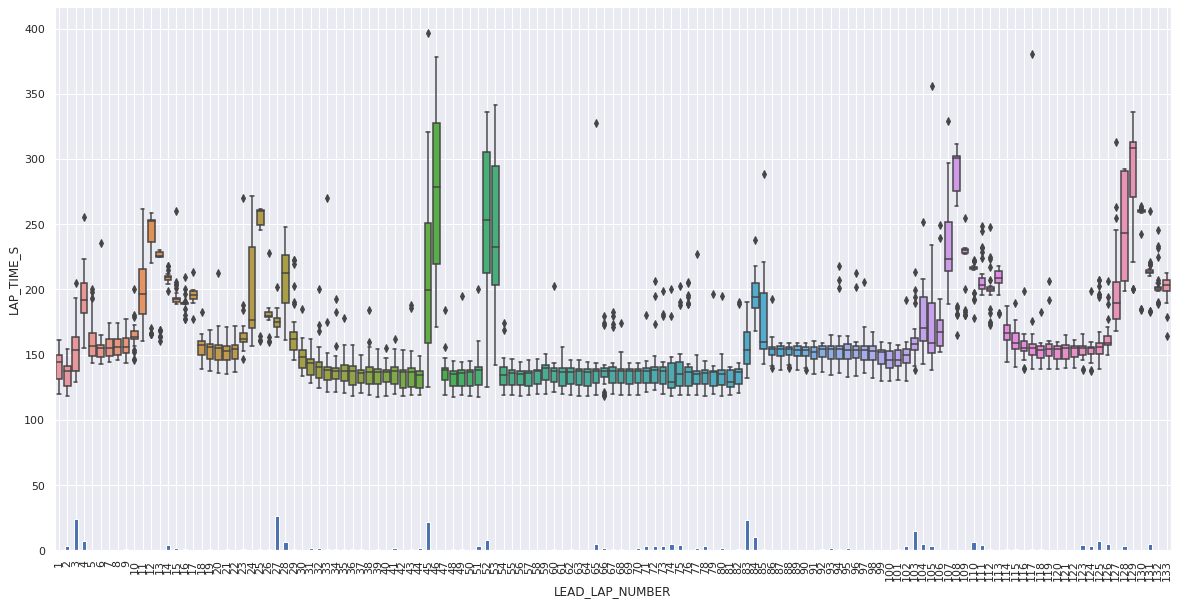

In [18]:
ax = sns.boxplot(x="LEAD_LAP_NUMBER", y="LAP_TIME_S", data=laptimes[laptimes['LAP_TIME_S']<500])
laptimes.groupby('LEAD_LAP_NUMBER')['INLAP'].apply(lambda x: x.sum()).plot(kind='bar', ax=ax);

## Simple Classifier

Can we build a simple K-means classifier with K=2 to identify slow laps? 

In [19]:
from sklearn.cluster import KMeans

Let's just do something really simple and see if we can classify based on the median and standard deviation of the laptimes.

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( laptimes_summary_stats[['median', 'std']] )

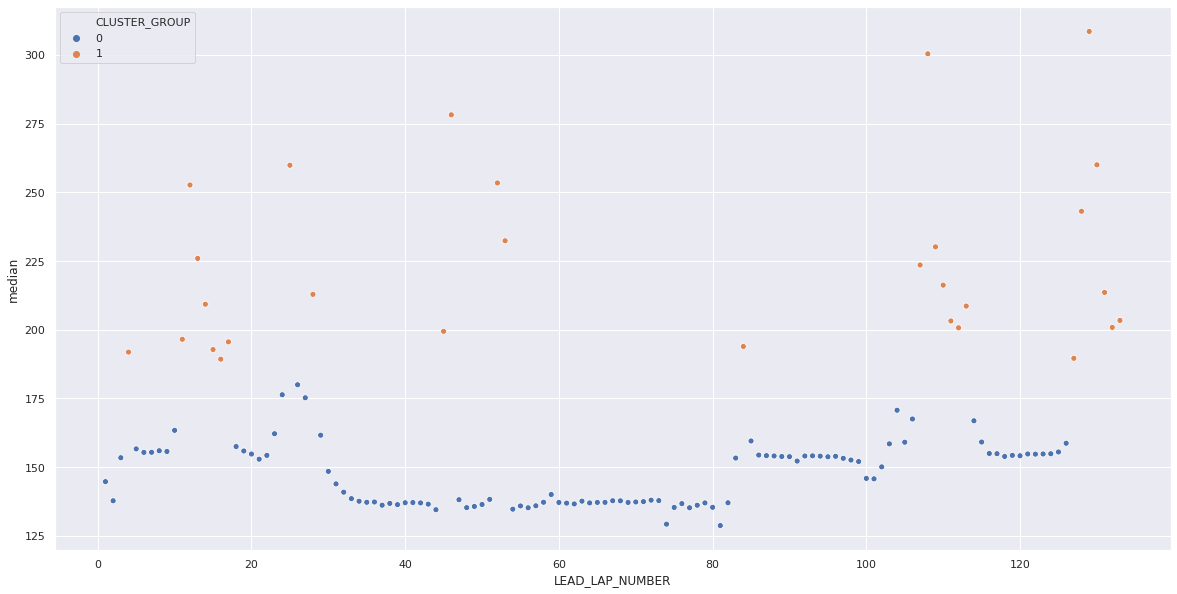

In [21]:
import numpy as np

laptimes_summary_stats['CLUSTER_GROUP'] = kmeans.labels_

#colours = np.where(laptimes_summary_stats['CLUSTER_GROUP'], 'red', 'green')
#laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='median', color=colours)
ax = sns.scatterplot(x="LEAD_LAP_NUMBER", y="median", hue = 'CLUSTER_GROUP',
                     data=laptimes_summary_stats.reset_index())


*(The classification is worsned, if anything, if we add the leader laptime deltas in.)*

How about over all the laptimes? Though we need to find a way of handling `NaN`s and maybe doing something to normalise pit stop times to something closer to the median lap time on a given lead lap? Or do we want to keep that extra signal in?

In [22]:
tmp = laptimes[['LEAD_LAP_NUMBER','NUMBER','CLEAN_LAP_TIME_S','INLAP']]

#Let's try voiding times that are pit times
tmp.loc[tmp['INLAP'], 'CLEAN_LAP_TIME_S'] = NaN


# Now create a table of car laptimes by leadlap

#Some cars may have multiple laptimes recorded on one lead lap
#in this case, we need to reduce the multiple times to a single time, eg min, or mean
car_by_lap = tmp.pivot_table(index='LEAD_LAP_NUMBER', columns='NUMBER', values='CLEAN_LAP_TIME_S', aggfunc='min')
car_by_lap.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


NUMBER,1,11,17,26,28,29,3,31,36,37,...,81,82,86,88,90,91,92,95,97,98
LEAD_LAP_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,126.349,125.631,123.259,130.204,132.841,129.335,123.739,132.132,131.763,134.179,...,144.903,145.413,161.521,150.242,151.430,147.990,146.417,145.979,144.495,155.734
2,120.417,120.443,120.213,125.028,127.616,124.843,120.193,126.243,125.979,127.074,...,137.703,138.048,NaN,137.769,141.434,138.023,137.991,NaN,NaN,146.244
3,NaN,128.686,129.886,NaN,NaN,NaN,NaN,134.128,NaN,NaN,...,NaN,NaN,NaN,153.401,NaN,NaN,NaN,186.104,193.661,NaN
4,190.094,NaN,NaN,187.287,184.219,179.956,182.981,NaN,223.294,218.998,...,216.436,192.175,255.287,NaN,205.041,205.334,191.531,154.871,156.304,198.729
5,149.763,184.800,191.934,148.890,147.842,148.768,143.637,200.416,149.113,147.908,...,155.872,155.208,163.185,NaN,166.379,161.079,155.048,154.323,155.312,162.983


In [23]:
#Fill na with row mean, though it requires a hack as per ??
#SHould we use mean, median, or min?

car_by_lap_clean = car_by_lap.T.fillna(car_by_lap.mean(axis=1)).T
car_by_lap_clean.head()

NUMBER,1,11,17,26,28,29,3,31,36,37,...,81,82,86,88,90,91,92,95,97,98
LEAD_LAP_NUMBER,,,,,,,,,,,,,,,,,,,,,
1,126.349000,125.631000,123.259000,130.204000,132.841000,129.335000,123.739000,132.132000,131.763000,134.179000,...,144.903000,145.413000,161.521000,150.242000,151.430000,147.990000,146.417000,145.979000,144.495000,155.734000
2,120.417000,120.443000,120.213000,125.028000,127.616000,124.843000,120.193000,126.243000,125.979000,127.074000,...,137.703000,138.048000,132.201097,137.769000,141.434000,138.023000,137.991000,132.201097,132.201097,146.244000
3,151.675222,128.686000,129.886000,151.675222,151.675222,151.675222,151.675222,134.128000,151.675222,151.675222,...,151.675222,151.675222,151.675222,153.401000,151.675222,151.675222,151.675222,186.104000,193.661000,151.675222
4,190.094000,197.135741,197.135741,187.287000,184.219000,179.956000,182.981000,197.135741,223.294000,218.998000,...,216.436000,192.175000,255.287000,197.135741,205.041000,205.334000,191.531000,154.871000,156.304000,198.729000
5,149.763000,184.800000,191.934000,148.890000,147.842000,148.768000,143.637000,200.416000,149.113000,147.908000,...,155.872000,155.208000,163.185000,162.354806,166.379000,161.079000,155.048000,154.323000,155.312000,162.983000


In [24]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( car_by_lap_clean )

Now let's highlight clustered laps and see if we've picked out the slow ones...

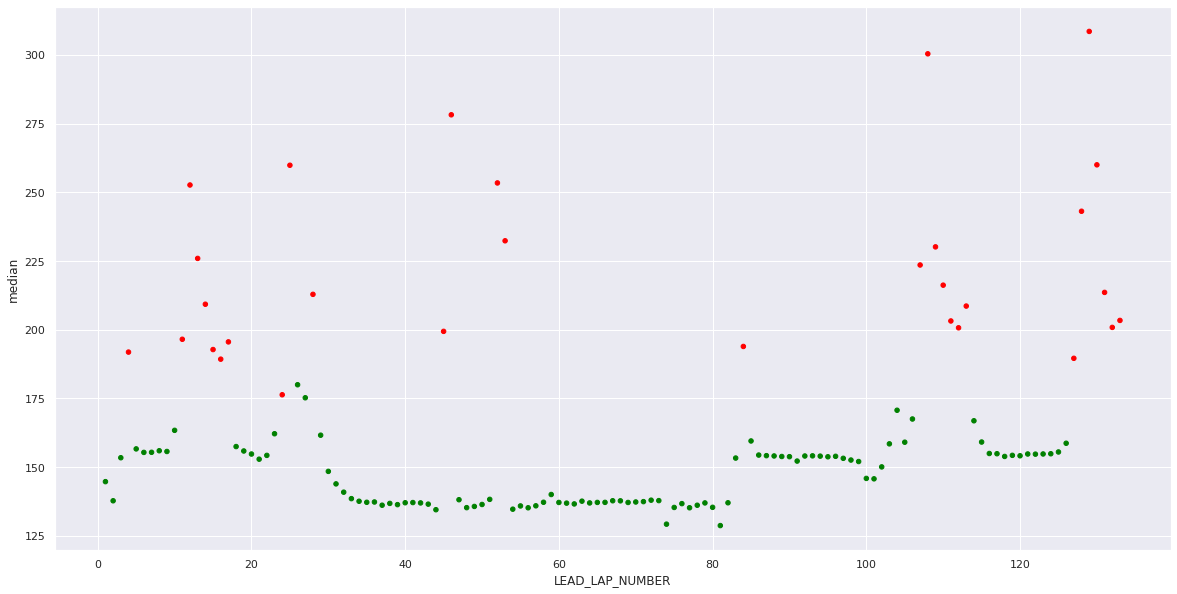

In [25]:
laptimes_summary_stats['CLUSTER_GROUP'] = kmeans.labels_

colours = np.where(laptimes_summary_stats['CLUSTER_GROUP'], 'red', 'green')

#ax = sns.scatterplot(x="LEAD_LAP_NUMBER", y="median", hue = 'CLUSTER_GROUP' data=tips)
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='median', color=colours)

Seems to be pretty good, though around lap 25 a couple of misclassifications, perhaps?

*(Using actual INLAP times, rather than non-pitting lead lap average times for INLAPS, doesn't seem to affect the classification?)*

This also differs from the simple classification based on median/std by identifying lead lap 24 as an atypical laptime event?

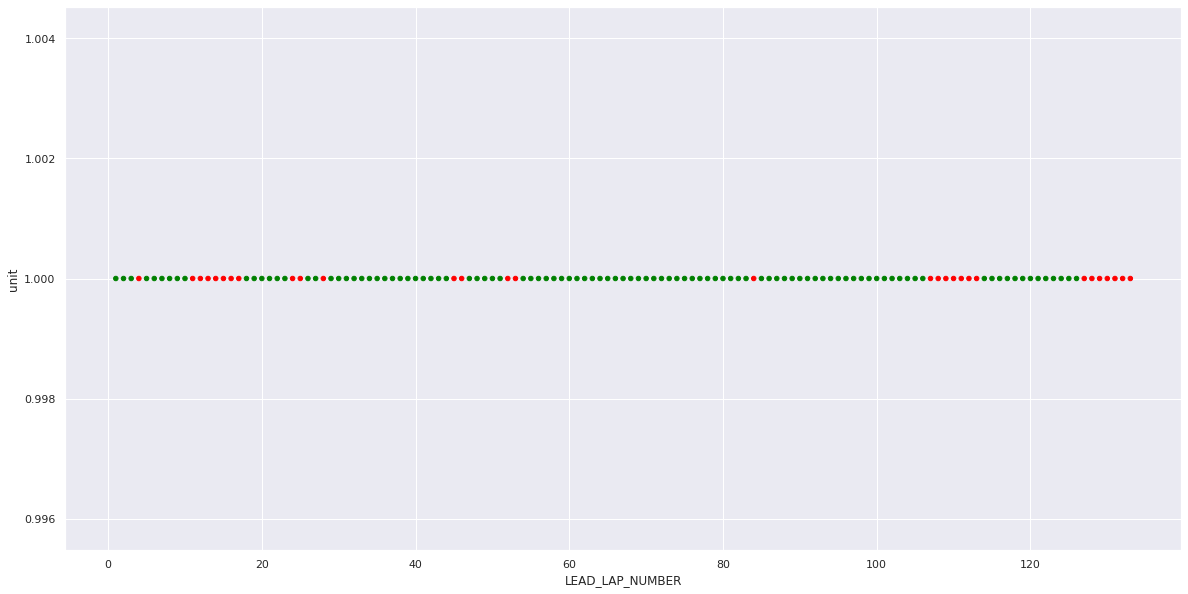

In [26]:
laptimes_summary_stats['unit']=1
laptimes_summary_stats.reset_index().plot(kind='scatter', x='LEAD_LAP_NUMBER', y='unit', color=colours)

*(It doesn't make any difference if we add the summary stats in too...)*

### Streak Detection

There are several receipes out there for streak detection. It may be useful to try to collect them and then come up with a best practice way of calculating streaks?

In [27]:
colours_df = pd.DataFrame({'event':[c!='red' for c in colours]})
#Set the index to be lead lap number - indexed on 1 rather than 0
colours_df.index += 1

colours_df.head()

,event
1,True
2,True
3,True
4,False
5,True


In [28]:
#via https://stackoverflow.com/a/51626783/454773

def streak(dfc):
    ''' Streak calculation: take a dataframe column containing a list of Boolean values
        and return a list of paired values containing index values of the start and end of each streak
        for the True boolean value. '''
    return ((~dfc).cumsum()[dfc]
            .reset_index()
            .groupby(['event'])['index']
            .agg(['first','last'])
            .values
            .tolist())

streak(colours_df['event']), streak(~colours_df['event'])

([[1, 3],
  [5, 10],
  [18, 23],
  [26, 27],
  [29, 44],
  [47, 51],
  [54, 83],
  [85, 106],
  [114, 126]],
 [[4, 4],
  [11, 17],
  [24, 25],
  [28, 28],
  [45, 46],
  [52, 53],
  [84, 84],
  [107, 113],
  [127, 133]])

In [29]:
def streak_len(streak_list, lap_index = 1):
    ''' Return a dataframe showing streak lap start, end, length. '''
    tmp_df = pd.DataFrame(streak_list, columns=['Start', 'Stop'])
    tmp_df['Length'] = tmp_df['Stop'] - tmp_df['Start'] + 1
    #Align index to first lap number
    tmp_df.index += lap_index
    return tmp_df

streak_len( streak( ~colours_df['event'] ) )

,Start,Stop,Length
1,4,4,1
2,11,17,7
3,24,25,2
4,28,28,1
5,45,46,2
6,52,53,2
7,84,84,1
8,107,113,7
9,127,133,7


## Simple Race History Chart

One of the ways we can use the atypical laptime indicator is to neutralise affected areas of the race history chart, making it (arguably), easier to read.

For example, a raw race history chart, which shows how the lap times for each driver compare over the course of a race by comparison to the winner's mean laptime, might look like the following:

In [30]:
#Get the number of the winning car
#which is to say, the one in first position at the end of the race
LAST_LAP = laptimes['LEAD_LAP_NUMBER'].max()

winner = laptimes[(laptimes['LAP_NUMBER']==LAST_LAP) & 
                  (laptimes['POS']==1)]['NUMBER'].iloc[0]
winner

'8'

In [31]:
#Get the mean laptime for the winner
winner_mean_laptime_s = laptimes[laptimes['NUMBER']==winner]['LAP_TIME_S'].mean().round(decimals=3)
winner_mean_laptime_s

155.497

In [32]:
#Calculate the "race history" laptimes
#?? laptimes['LEAD_LAP_NUMBER'] gives track position? laptimes['LAP_NUMBER'] give race history
laptimes['RACE_HISTORY_ELAPSED_LAP_TIME_S'] = (winner_mean_laptime_s * laptimes['LAP_NUMBER']) - laptimes['ELAPSED_S']


In [33]:
#Let's filter, for now, by just the top 10 cars
top10 = laptimes[laptimes['LEAD_LAP_NUMBER']==LAST_LAP].sort_values(['LEAD_LAP_NUMBER', 'POS'])[['NUMBER']].reset_index(drop=True).head(10)
top10.index +=1

We can add highlighted areas to the chart to identify atypical laps.

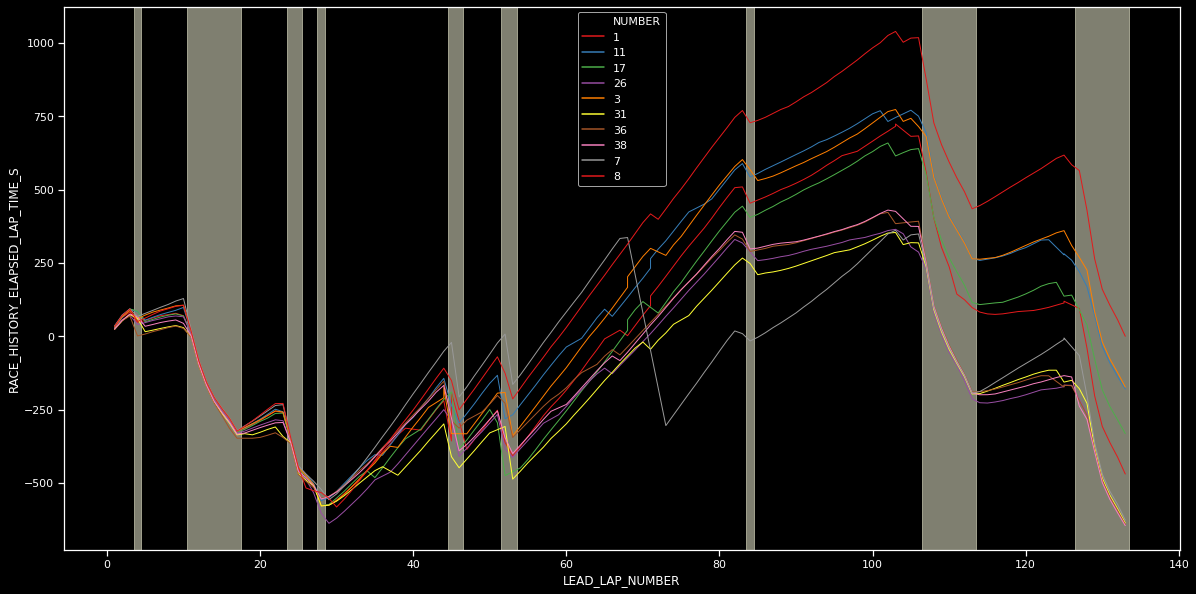

In [34]:
sns.set(style="ticks")
plt.style.use("dark_background")

#Setting the palette size is a hack: https://github.com/mwaskom/seaborn/issues/1515#issuecomment-482189290
data = laptimes[laptimes['NUMBER'].isin(top10['NUMBER'])]

ax = sns.lineplot(x="LEAD_LAP_NUMBER", y="RACE_HISTORY_ELAPSED_LAP_TIME_S",
                  units = 'NUMBER', hue = 'NUMBER', palette=sns.color_palette("Set1", len(data['NUMBER'].unique())),
                  estimator=None, lw=1,
                  data=data)

#Let's add in some indicators showing the atypical laps

def atypical_lap_band(row, ax):
    ax.axvspan(row['Start']-0.5, row['Stop']+0.5, alpha=0.5, color='lightyellow')
    
streak_len( streak( ~colours_df['event'] ) ).apply(lambda x: atypical_lap_band(x, ax), axis=1);

TO DO - if a car is lapped it may have more that on lap time per lead lap - we need to plot the one with largest elapsed time. ??Are we losing a row somewhere where a car is lapped?

In [35]:
# Race history chart - if we plot the lead lap, we get the track position?

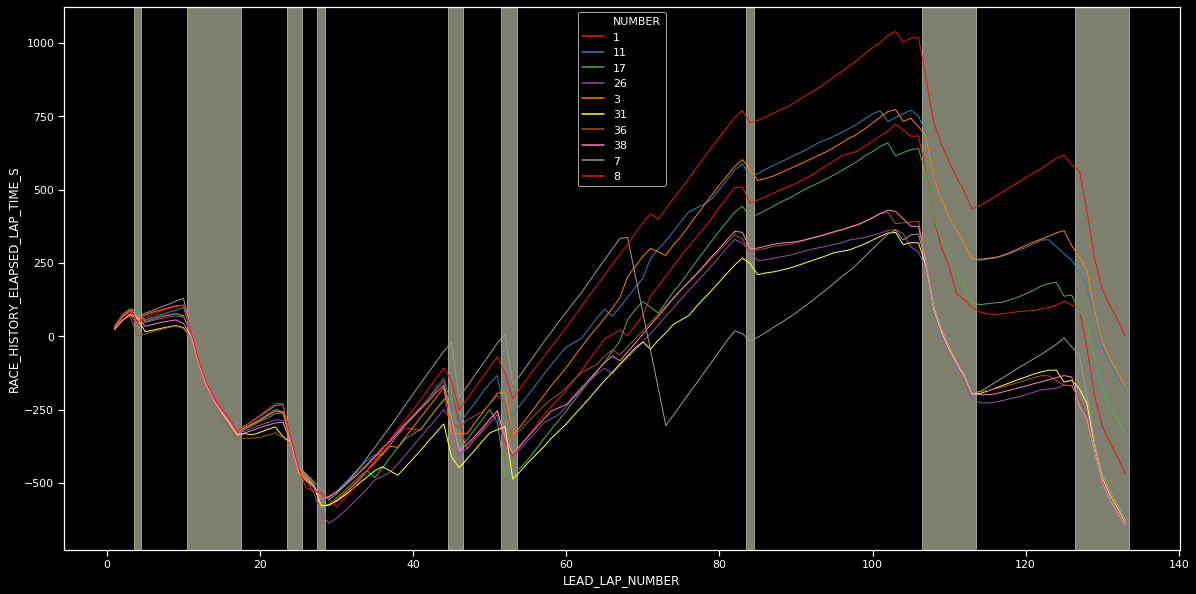

In [36]:
data = laptimes[laptimes['NUMBER'].isin(top10['NUMBER'])].groupby(['LEAD_LAP_NUMBER','NUMBER'])['RACE_HISTORY_ELAPSED_LAP_TIME_S'].max().reset_index()

ax = sns.lineplot(x="LEAD_LAP_NUMBER", y="RACE_HISTORY_ELAPSED_LAP_TIME_S",
                  units = 'NUMBER', hue = 'NUMBER', palette=sns.color_palette("Set1", len(data['NUMBER'].unique())),
                  estimator=None, lw=1,
                  data=data)

streak_len( streak( ~colours_df['event'] ) ).apply(lambda x: atypical_lap_band(x, ax), axis=1);

One thing we notice about the race history chart is that safety car periods can result in an increase in typical laptimes which can dramatically affect the appearance of the chart.

However, if we identify laps with atypical laptimes across the field, we can 'neutralise" those laps by replacing the recorded times with dummy laptimes.

One model for generating dummy laptimes is to identify a "laptime corrective" in the form of a subtractive term:

`leader_neutralised_lap_time = leader_laptime_on_slow_lap - corrective`

So what should that `leader_neutralised_lap_time` be?

If we want to "neutralise" the safety car lap times, then we might expect the race history chart to show a flat line for the cars travelling at a neutralised pace.

The neutralised pace should thus be set to the winner's mean laptime over the non-neutralised laps (the neutralised laps should not otherwise change the mean laptime basis that defines the race history chart).

But whose pace should we use for the basis of neutralisation?

Ideally, we want to use the pace that defines the pace of the field. If a safety car is controlling race pace, then it makes sense to use the laptime of the leader on a given lap as the race defining pace and define a corrective based on this pace.

That is:

```python
leaders_neutralised_lap_time = winners_non_neutralised_laps_mean_lap_time

```

We can create a corrective for each laptime as follows:

```python

leaders_neutralised_lap_time = leaders_lap_time_on_neutralisation_lap - corrective_on_neutralisation_lap

```

which gives:

```python
corrective_on_neutralisation_lap = leaders_lap_time_on_neutralisation_lap - winners_non_neutralised_laps_mean_lap_time
```

and more generally:

```python
neutralised_lap_time = lap_time_on_neutralisation_lap - corrective_on_neutralisation_lap

```

*Bounds get fiddly if atypical laps appear at a fence post (first lap, last lap), so for now let's use the fact the first lap is clear to set the neutralised lap time during an atypical stint to be the lap time of the leader on the lap before the atypical run.*

Let's start by getting hold of the lap numbers for the laps we want to neutralise, and the lap number of the laps at the start of neutralisation periods:

In [37]:
#Get the lap numbers for the atypical laps (that is, the laps we want to neutralise)
NEUTRALISED_LAPS = laptimes_summary_stats[laptimes_summary_stats['CLUSTER_GROUP']==1].index

#As a convenience, we may wish to get the first lap in a neutralisation period
NEUTRALISED_LAP_STARTS = streak_len( streak( ~colours_df['event'] ) )['Start']

The corrective is the difference between the lap leader's time during a neutralisation period and the neutralised lap target time.

The neutralised lap target time is the winner's mean lap time over the non-neutralised laps.

In [38]:
##Set the target time to the mean of the winner on just the typical laps?
winners_mean_typical = laptimes[(laptimes['NUMBER']==winner) & ~(laptimes['LEAD_LAP_NUMBER'].isin(NEUTRALISED_LAPS))]['LAP_TIME_S'].mean().round(decimals=3)
winners_mean_typical

134.249

Set up a dummy column, `desired`, to be the lap time we want the leader to have on laps in the neutralisation period, then generate the corrective as the difference between their actual lap time and this desired lap time for the neutralisation laps. Set the dummy `desired` column to the dummy value 0 otherwise (that is, on racing laps).

In [39]:
colours_df['desired'] = 0
colours_df.loc[colours_df.index.isin(NEUTRALISED_LAPS), 'desired'] = winners_mean_typical
colours_df['desired'].fillna(method='ffill', inplace=True)

#The corrective basis is then the lap time of the lead lap leader
colours_df['corrective_basis'] = laptimes[laptimes['POS']==1].set_index('LEAD_LAP_NUMBER')['LAP_TIME_S']

colours_df['corrective'] = 0
colours_df.loc[colours_df.index.isin(NEUTRALISED_LAPS), 'corrective'] = colours_df['corrective_basis'] - colours_df['desired']

colours_df.head()

,event,desired,corrective_basis,corrective
1,True,0.000,120.155,0.000
2,True,0.000,118.383,0.000
3,True,0.000,134.361,0.000
4,False,134.249,162.912,28.663
5,True,0.000,145.328,0.000


In [40]:
#We now need to apply the lap based correctives to each lap in the laptimes dataset
laptimes = pd.merge(laptimes, colours_df['corrective'], left_on='LEAD_LAP_NUMBER', right_index=True)

In [41]:
#Repeat the race history calculations using the neutralised lap times
laptimes['NEUTRALISED_LAP_TIME_S'] = laptimes['LAP_TIME_S'] - laptimes['corrective']
laptimes['ELAPSED_NEUTRALISED_LAP_TIME_S'] = laptimes.groupby('NUMBER')['NEUTRALISED_LAP_TIME_S'].cumsum()

In [42]:
neutralised_winner_mean_laptime_s = laptimes[laptimes['NUMBER']==winner]['NEUTRALISED_LAP_TIME_S'].mean().round(decimals=3)
neutralised_winner_mean_laptime_s


134.145

In [43]:
#Calculate the "neutralised race history" laptimes
#If we multiply by lead_lap_number we can get track position? TO DO
laptimes['NEUTRALISED_RACE_HISTORY_ELAPSED_LAP_TIME_S'] = (neutralised_winner_mean_laptime_s * laptimes['LAP_NUMBER']) - laptimes['ELAPSED_NEUTRALISED_LAP_TIME_S']


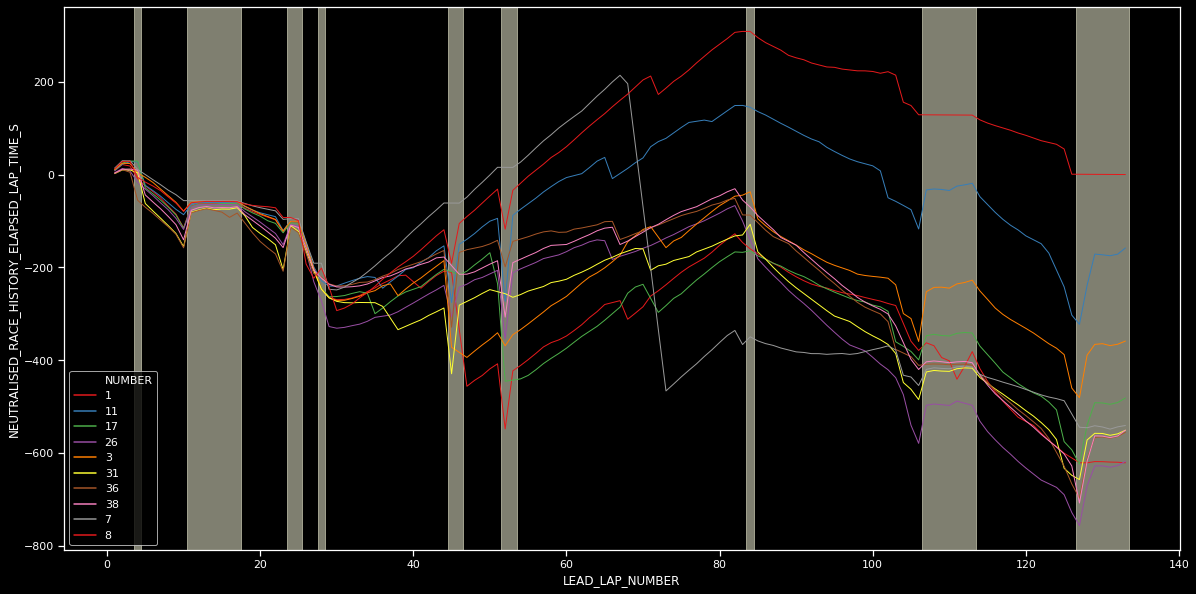

In [47]:
#Should make a function for this
data = laptimes[laptimes['NUMBER'].isin(top10['NUMBER'])].groupby(['LEAD_LAP_NUMBER','NUMBER'])['NEUTRALISED_RACE_HISTORY_ELAPSED_LAP_TIME_S'].max().reset_index()

ax = sns.lineplot(x="LEAD_LAP_NUMBER", y="NEUTRALISED_RACE_HISTORY_ELAPSED_LAP_TIME_S",
                  units = 'NUMBER', hue = 'NUMBER', palette=sns.color_palette("Set1", len(data['NUMBER'].unique())),
                  estimator=None, lw=1,
                  data=data)

#Let's add in some indicators showing the atypical laps

def atypical_lap_band(row, ax):
    ax.axvspan(row['Start']-0.5, row['Stop']+0.5, alpha=0.5, color='lightyellow')
    
streak_len( streak( ~colours_df['event'] ) ).apply(lambda x: atypical_lap_band(x, ax), axis=1);

In [45]:
top10

,NUMBER
1,8
2,3
3,11
4,17
5,1
6,7
7,31
8,26
9,36
10,38


In [46]:
laptimes[(laptimes['NUMBER']=='31') & (laptimes['LAP_NUMBER']>70)& (laptimes['LAP_NUMBER']<90) ][['LAP_NUMBER','LEAD_LAP_NUMBER']]

,LAP_NUMBER,LEAD_LAP_NUMBER
979,71,73
980,72,74
981,73,76
982,74,77
983,75,78
984,76,79
985,77,80
986,78,81
987,79,82
988,80,83
